In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
from utils import read_labels, draw_image, image_to_yolo_input, Object
from PIL import Image as Img

In [2]:
#TODO: read from config

image_width = 416
image_height = 416
grid_width = 13
grid_height = 13

cell_width = image_width / grid_width
cell_height = image_height / grid_height

boxes = 5

activation_alpha = 0.1

object_scale = 5
noobject_scale = 1
class_scale = 1
coord_scale = 1

threshhold = 0.3

anchors = [[1.05, 1.65], [2.44, 4.13], [4.01, 8.46], [7.62, 5.13], [9.97, 10.43]] # got them from KMeans experiments ipynb

labels_dir = "./labels.txt"

In [3]:
labels, labels_count = read_labels(labels_dir)


labels_count = 0 # TODO: remove when implementing classification

print(labels_count)
print(labels)

0
['horse', 'diningtable', 'sofa', 'train', 'bird', 'aeroplane', 'person', 'boat', 'bottle', 'motorbike', 'bus', 'cat', 'pottedplant', 'car', 'dog', 'bicycle', 'sheep', 'cow', 'tvmonitor', 'chair']


In [4]:
layers = []

layers.append(Input(shape=(image_width, image_height, 3)))

layers.append(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_1"))
layers.append(BatchNormalization(name = "norm_1"))
layers.append(LeakyReLU(name = "leaky_1", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_1"))

layers.append(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_2"))
layers.append(BatchNormalization(name = "norm_2"))
layers.append(LeakyReLU(name = "leaky_2", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_2"))

layers.append(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_3"))
layers.append(BatchNormalization(name = "norm_3"))
layers.append(LeakyReLU(name = "leaky_3", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_3"))

layers.append(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_4"))
layers.append(BatchNormalization(name = "norm_4"))
layers.append(LeakyReLU(name = "leaky_4", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_4"))

layers.append(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_5"))
layers.append(BatchNormalization(name = "norm_5"))
layers.append(LeakyReLU(name = "leaky_5", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_5"))

layers.append(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_6"))
layers.append(BatchNormalization(name = "norm_6"))
layers.append(LeakyReLU(name = "leaky_6", alpha = activation_alpha))
#layers.append(MaxPooling2D(name = "maxpool_6", pool_size = (2, 2), strides = (1, 1)))

layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_7"))
layers.append(BatchNormalization(name = "norm_7"))
layers.append(LeakyReLU(name = "leaky_7", alpha = activation_alpha))

layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_8"))
layers.append(BatchNormalization(name = "norm_8"))
layers.append(LeakyReLU(name = "leaky_8", alpha = activation_alpha))

layers.append(Conv2D(filters = (boxes * (4 + 1 + labels_count)), kernel_size = (1, 1), padding = "same", name="conv_9"))

layers.append(Reshape(target_shape = (grid_width, grid_height, boxes, 5 + labels_count), name = "output"))

model = Sequential(layers = layers, name = "tiny yolov2 voc")
model.summary()

W1209 22:53:18.965026 14680 deprecation.py:506] From C:\Users\Gencho\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "tiny yolov2 voc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 416, 416, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 416, 416, 16)      0         
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 208, 208, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 208, 208, 32)      4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 208, 208, 32)      128       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 208, 208, 32)  

In [5]:
def encode_y_true_from_annotatoin(annotation):
    pass

def custom_loss(y_true, y_pred):
    pass

1.2019230769230769
0.9014423076923077


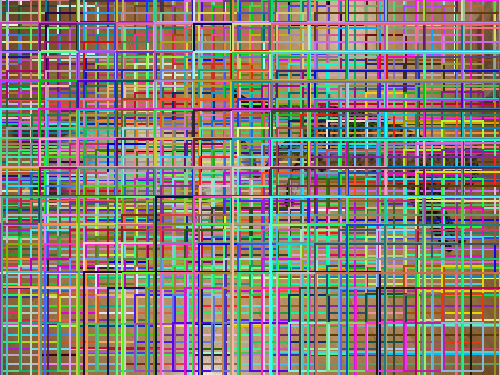

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def decode_prediction(y_pred):
    objects = []
    
    for row in range(grid_height):
        for col in range(grid_width):
            for box in range(boxes):
                tx, ty, tw, th, to = y_pred[row, col, box]
                
                bx = sigmoid(tx) + col * cell_width
                by = sigmoid(ty) + row * cell_height
                
                pw, ph = anchors[box]
                
                bw = pw * np.exp(tw)
                bh = ph * np.exp(tw)
                
                bw *= cell_width
                bh *= cell_height
                
                conf = sigmoid(to)
                
                if(conf >= threshhold):
                    objects.append(Object(xmin = bx - bw/2, xmax = bx + bw/2, ymin = by - bh/2, ymax = by + bh/2, conf = conf))
    return objects

def feed_forward(image_path):
    im = Img.open(image_path)
    
    width_scale = im.width / image_width
    height_scale = im.height / image_height
    print(width_scale)
    print(height_scale)
    
    im = im.resize((image_width, image_height))
    im = np.array(im, np.float32)
    im /= 255
    
    y_pred = model.predict(np.array([im]))[0]
    
    objects = decode_prediction(y_pred)
    
    for obj in objects:
        obj.xmin = obj.xmin * width_scale
        obj.xmax = obj.xmax * width_scale
        obj.ymin = obj.ymin * height_scale
        obj.ymax = obj.ymax * height_scale
    
    draw_image(image_path, objects)
    

testannotation = r'.\\VOCdevkit\\VOC2007\\Annotations\\000019.xml'
testimage = r'.\\VOCdevkit\\VOC2007\\JPEGImages\\000019.jpg'

feed_forward(testimage)